# The Battle of the Neighborhoods (week 2): *Opening a Pub in Aberdeen*

### Tip:
- Copy the URL of this notebook and enter it into [https://nbviewer.jupyter.org/](https://nbviewer.jupyter.org/) to see the interactive maps that I plot during the notebook. 

## Introduction
This notebook is a part of the capstone project of the Applied Data Science Capstone from IBM/Coursera. The purpose of this project - the research problem (opportunity) that I have selected - is to locate the most suitable area of Aberdeen to open a pub, based on two overarching criteria:

1. **There should be few other pubs in the area**
2. **There should be a sufficient amount of potential customers in the area**


Based on the abovementioned problem and criteria, the following *research question* was posed:

- **In which area of Aberdeen should an entrepreneur open a pub if they seek to minimize the number of other pubs in the area, while maximizing their reach to customers?**


Throughout this notebook I will use machine learning and other data science methods to attempt to answer the research question through analysis of structured and unstructed quantitative data.

## Data
In order to perform the necessary data analysis to answer the research question, I need to gather three types of data:

- **Data containing information about the different areas of Aberdeen and their locations (one of these will be the answer to the research question)**
- **Data containing information about pubs in Aberdeen (needed to determine if an area fulfills the first criterium)**
- **Data containing information about the population in Aberdeen´s areas (needed to determine if an area fulfills the second criterium)**

Three datasets were used for the majority of the data analysis related to the project:
- First, I gathered information about Aberdeen´s areas/wards, such as the names of each ward, their respective districts and geographical location (latitude and longitude) [here](https://www.doogal.co.uk/UKPostcodes.php?Search=AB). This was downloaded as a csv-file, loaded into the notebook, and assigned to the *ab_data*-variable.
- Next, I manually scraped information about the population of each ward from a [pdf-file](https://www.aberdeencity.gov.uk/sites/default/files/2019-08/2018%20Mid%20Year%20Population%20Estimates%20Wards%20%28All%20Persons%29.pdf), acquired through Aberdeen City Council´s webpage, into an excel file, before loading it into the notebook as *ab_pop*.
- Finally, location data from [Foursquare API](https://developer.foursquare.com/docs) was used to explore the different wards of Aberdeen with respect to pubs and other venues.

Some other datasets, which were used to gather specific information about the wards in Aberdeen, will be presented further on in this notebook.

## Importing the necessary packages

In [87]:
import pandas as pd
import numpy as np

import requests

import matplotlib.pyplot as plt
%matplotlib inline

import folium

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

## Data preprocessing

**Load the area- and population datasets, and assign them to *ab_data* and *ab_pop*, respectively:**

In [39]:
ab_data = pd.read_csv('AB postcodes (2).csv')
ab_pop = pd.read_excel('Population_data.xlsx')

**Check the size of the area dataset:**

In [40]:
print("The dataset cosists of {} rows and {} columns.".format(ab_data.shape[0], ab_data.shape[1]))

The dataset cosists of 17064 rows and 46 columns.


**Display the first five rows of the area dataset:**

In [41]:
ab_data.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,Quality,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code
0,AB10 1AB,Yes,57.149606,-2.096916,394235.0,806529.0,NJ942065,NaN,Aberdeen City,George St/Harbour,...,1,1,2019-11-23,Aberdeen,0.664246,AB,AB10,Scotland,Scottish Water,9C9V4WX3+R6
1,AB10 1AF,Yes,57.148707,-2.097806,394181.0,806429.0,NJ941064,NaN,Aberdeen City,George St/Harbour,...,1,1,2019-11-23,Aberdeen,0.558252,AB,AB10,Scotland,Scottish Water,9C9V4WX2+FV
2,AB10 1AG,Yes,57.149051,-2.097004,394230.0,806467.0,NJ942064,NaN,Aberdeen City,George St/Harbour,...,1,1,2019-11-23,Aberdeen,0.602541,AB,AB10,Scotland,Scottish Water,9C9V4WX3+J5
3,AB10 1AH,Yes,57.148080,-2.094664,394371.0,806359.0,NJ943063,NaN,Aberdeen City,George St/Harbour,...,1,1,2019-11-23,Aberdeen,0.543157,AB,AB10,Scotland,Scottish Water,9C9V4WX4+64
4,AB10 1AL,Yes,57.149528,-2.095419,394326.0,806520.0,NJ943065,NaN,Aberdeen City,George St/Harbour,...,1,0,2019-11-23,Aberdeen,0.676260,AB,AB10,Scotland,Scottish Water,9C9V4WX3+RR


**The dataset has a lot of redundant features. I decide to limit it to the columns *Ward*, *District*, *Latitude* and *Longitude*:**

In [42]:
ab_data = ab_data[['Ward', 'District', 'Latitude', 'Longitude']]
ab_data.head()

,Ward,District,Latitude,Longitude
0,George St/Harbour,Aberdeen City,57.149606,-2.096916
1,George St/Harbour,Aberdeen City,57.148707,-2.097806
2,George St/Harbour,Aberdeen City,57.149051,-2.097004
3,George St/Harbour,Aberdeen City,57.148080,-2.094664
4,George St/Harbour,Aberdeen City,57.149528,-2.095419


**In order to get a single entry for each ward/area, I group the dataset by *Ward* and *District*. I use the mean coordinates of the postcodes in the wards as a proxy for their geographic center:**

In [43]:
ab_data = ab_data.groupby(['Ward','District']).mean().reset_index()
ab_data.head(10)

,Ward,District,Latitude,Longitude
0,"Aboyne, Upper Deeside and Donside",Aberdeenshire,57.102629,-2.891397
1,Airyhall/Broomhill/Garthdee,Aberdeen City,57.128143,-2.135057
2,Badenoch and Strathspey,Highland,57.278146,-3.459058
3,Banchory and Mid Deeside,Aberdeenshire,57.056646,-2.536566
4,Banff and District,Aberdeenshire,57.632292,-2.616775
5,Brechin and Edzell,Angus,56.782538,-2.582795
6,Bridge of Don,Aberdeen City,57.189205,-2.108137
7,Buckie,Moray,57.676277,-2.957471
8,Central Buchan,Aberdeenshire,57.526149,-2.075585
9,Dyce/Bucksburn/Danestone,Aberdeen City,57.190166,-2.181515


**Because the research problem relates to locating well populated areas of Aberdeen, I am limiting the dataset to the wards located in the *Aberdeen City* district:**

In [50]:
ab_data = ab_data[ab_data['District']=='Aberdeen City']
ab_data.reset_index(drop=True, inplace=True)

In [51]:
ab_data

,Ward,District,Latitude,Longitude
0,Airyhall/Broomhill/Garthdee,Aberdeen City,57.128143,-2.135057
1,Bridge of Don,Aberdeen City,57.189205,-2.108137
2,Dyce/Bucksburn/Danestone,Aberdeen City,57.190166,-2.181515
3,George St/Harbour,Aberdeen City,57.151957,-2.096320
4,Hazlehead/Queens Cross/Countesswells,Aberdeen City,57.140381,-2.144622
5,Hilton/Woodside/Stockethill,Aberdeen City,57.164635,-2.130850
6,Kincorth/Nigg/Cove,Aberdeen City,57.111791,-2.096876
7,Kingswells/Sheddocksley/Summerhill,Aberdeen City,57.153805,-2.181091
8,Lower Deeside,Aberdeen City,57.111729,-2.222704
9,Midstocket/Rosemount,Aberdeen City,57.150807,-2.123160


In [48]:
ab_pop

,Ward,Population
0,Airyhall/Broomhill/Garthdee,16664
1,Bridge of Don,19212
2,Dyce/Bucksburn/Danestone,18827
3,George St/Harbour,20461
4,Hazlehead/Queens Cross/Countesswells,20562
5,Hilton/Woodside/Stockethill,16008
6,Kincorth/Nigg/Cove,16383
7,Kingswells/Sheddocksley/Summerhill,15196
8,Lower Deeside,16120
9,Midstocket/Rosemount,14594


**Now the two datasets are contain the same entries: one for each ward in Aberdeen City. Therefore, they can now be merged into one dataset, *ab_popdata*:**

In [52]:
ab_popdata = pd.merge(ab_data, ab_pop, on='Ward')

In [53]:
ab_popdata

,Ward,District,Latitude,Longitude,Population
0,Airyhall/Broomhill/Garthdee,Aberdeen City,57.128143,-2.135057,16664
1,Bridge of Don,Aberdeen City,57.189205,-2.108137,19212
2,Dyce/Bucksburn/Danestone,Aberdeen City,57.190166,-2.181515,18827
3,George St/Harbour,Aberdeen City,57.151957,-2.096320,20461
4,Hazlehead/Queens Cross/Countesswells,Aberdeen City,57.140381,-2.144622,20562
5,Hilton/Woodside/Stockethill,Aberdeen City,57.164635,-2.130850,16008
6,Kincorth/Nigg/Cove,Aberdeen City,57.111791,-2.096876,16383
7,Kingswells/Sheddocksley/Summerhill,Aberdeen City,57.153805,-2.181091,15196
8,Lower Deeside,Aberdeen City,57.111729,-2.222704,16120
9,Midstocket/Rosemount,Aberdeen City,57.150807,-2.123160,14594


**This concludes the preprocessing of the data. Next, I will go on to analyze the data, and attempt to answer the research question.**

## Exploratory data analysis

***I start off with some descriptive statistics of the *ab_popdata* dataset:***

In [57]:
print("The total population of Aberdeen City in 2018 was {}.".format(ab_popdata['Population'].sum()))
ab_popdata.describe()

The total population of Aberdeen City in 2018 was 227560.


,Latitude,Longitude,Population
count,13.000000,13.000000,13.000000
mean,57.150947,-2.136853,17504.615385
std,0.025124,0.039626,2377.228833
min,57.111729,-2.222704,14594.000000
25%,57.137055,-2.158188,16008.000000
50%,57.151957,-2.130850,16663.000000
75%,57.164635,-2.104663,19212.000000
max,57.190166,-2.095906,21804.000000


**Observation: The average population of Aberdeen City´s 13 wards is approximately 17505, with the least populated ward having 14594 inhabitants, while the most populated has 21804. This means that the wards are quite similar in terms of population, with an average 'growth' of 600 inhabitants from the least populated- through the most populated ward.**

**Visualizing the population of the wards in Aberdeen City:**

Text(0.5, 0, 'Population')

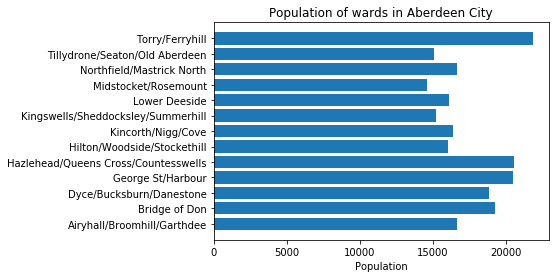

In [65]:
plt.barh(ab_popdata['Ward'],ab_popdata['Population'])
plt.title('Population of wards in Aberdeen City')
plt.xlabel('Population')

**Visualizing the wards (black and white markers) on a map of Aberdeen City:**

In [67]:
latitude = ab_popdata.Latitude.mean()
longitude = ab_popdata.Longitude.mean()

ab_map = folium.Map(location=[latitude, longitude], zoom_start=10.5)

for lat, lng, ward, dis in zip(ab_popdata['Latitude'], ab_popdata['Longitude'], ab_popdata['Ward'], ab_popdata['District']):
    label = '{}, {}'.format(ward, dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color='white',
        fill_opacity=0.4,
        parse_html=False).add_to(ab_map)
    
ab_map    

**Observation: Four of the wards are situated in the outskirts of Aberdeen City, while the remaining nine wards are located closer to the city centre.**

## Data analysis

**In order to be able to fetch the location data from Aberdeen, specifically information about the different venues in Aberdeen - where I will be looking for pubs - I have to enter my Foursquare credentials to access Foursquare API´s location data:**

In [68]:
client_id = 'FLRH4PNSIL0GXEWJV3YAS1IK1VDZTRFDPKQSERDZUXW22W0V'
client_secret = 'INYWU5KF5VLJ0QTDGHXRCJP1RU0FTF0CQ1MJ2WSN32CSLXIV'
version = '20180605'

**Next, I define a function, *GetNearbyVenues*, that will retrive a certain number of venues (*limit*) around (*radius*) one or several given geographical area(s) (*latitudes*, *longitudes*):**

In [72]:
def GetNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward Latitude', 
                  'Ward Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Next, I use the GetNearbyVenues function to retrieve the venues in Aberdeen city. Since the map above suggested that not all of the wards in Aberdeen City are located close to each other, I use a radius of 2000 meters to catch the different venues in each ward. I set a limit of 200 venues:**

In [78]:
limit = 200

ab_venues = GetNearbyVenues(names = ab_popdata['Ward'],
                            latitudes = ab_popdata['Latitude'], longitudes = ab_popdata['Longitude'],
                            radius = 2000)

Airyhall/Broomhill/Garthdee
Bridge of Don
Dyce/Bucksburn/Danestone
George St/Harbour
Hazlehead/Queens Cross/Countesswells
Hilton/Woodside/Stockethill
Kincorth/Nigg/Cove
Kingswells/Sheddocksley/Summerhill
Lower Deeside
Midstocket/Rosemount
Northfield/Mastrick North
Tillydrone/Seaton/Old Aberdeen
Torry/Ferryhill


**Let´s check the size of the resulting dataframe of venues in Aberdeen City, and display its first rows:**

In [79]:
print(ab_venues.shape)
ab_venues.head()

(573, 7)


,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Airyhall/Broomhill/Garthdee,57.128143,-2.135057,Palm Court Hotel,57.133499,-2.145895,Restaurant
1,Airyhall/Broomhill/Garthdee,57.128143,-2.135057,Malmaison Aberdeen,57.140690,-2.135394,Hotel
2,Airyhall/Broomhill/Garthdee,57.128143,-2.135057,David Lloyd Aberdeen,57.120471,-2.127772,Gym / Fitness Center
3,Airyhall/Broomhill/Garthdee,57.128143,-2.135057,Cafe Cognito,57.140209,-2.124997,Café
4,Airyhall/Broomhill/Garthdee,57.128143,-2.135057,Duthie Park,57.129696,-2.106995,Park


**This looks promising. However, if I want to perform a quantitative analysis I have to transform this into a sparse dataframe, containing one entry for each ward, as well as one column for each category of venues, and 1´s or 0´s indicating whether a venue of a given category is located in the ward:**

In [80]:
ab_sparse = pd.get_dummies(ab_venues[['Venue Category']], prefix="", prefix_sep="")

ab_sparse['Ward'] = ab_venues['Ward'] 

ab_sparse = pd.merge(ab_venues['Ward'], ab_sparse)

ab_sparse.head()

,Ward,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Auto Workshop,Bakery,Bar,...,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Theater,Theme Park,Trail,Turkish Restaurant,Warehouse Store,Whisky Bar
0,Airyhall/Broomhill/Garthdee,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Airyhall/Broomhill/Garthdee,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Airyhall/Broomhill/Garthdee,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Airyhall/Broomhill/Garthdee,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Airyhall/Broomhill/Garthdee,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**To get a single entry for each ward, showing the proportion of all venues in a given ward made up of each venue category, I group the sparse dataframe by *Ward*, and assign it to a new dataframe, *ab_grouped*:**

In [82]:
ab_grouped = ab_sparse.groupby('Ward').mean().reset_index()
ab_grouped

,Ward,Airport Lounge,Airport Service,American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Auto Workshop,Bakery,Bar,...,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Theater,Theme Park,Trail,Turkish Restaurant,Warehouse Store,Whisky Bar
0,Airyhall/Broomhill/Garthdee,0.000000,0.000000,0.022727,0.00,0.00,0.0,0.022727,0.000000,0.068182,...,0.022727,0.068182,0.00,0.00,0.00,0.00,0.000000,0.022727,0.000000,0.00
1,Bridge of Don,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.083333,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00
2,Dyce/Bucksburn/Danestone,0.090909,0.045455,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.136364,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00
3,George St/Harbour,0.000000,0.000000,0.000000,0.01,0.01,0.0,0.000000,0.000000,0.110000,...,0.010000,0.050000,0.01,0.01,0.01,0.00,0.000000,0.000000,0.000000,0.01
4,Hazlehead/Queens Cross/Countesswells,0.000000,0.000000,0.024390,0.00,0.00,0.0,0.000000,0.000000,0.121951,...,0.024390,0.073171,0.00,0.00,0.00,0.00,0.024390,0.024390,0.000000,0.00
5,Hilton/Woodside/Stockethill,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.023256,...,0.000000,0.093023,0.00,0.00,0.00,0.00,0.000000,0.000000,0.046512,0.00
6,Kincorth/Nigg/Cove,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.166667,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00
7,Kingswells/Sheddocksley/Summerhill,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.222222,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00
8,Lower Deeside,0.000000,0.000000,0.000000,0.00,0.00,0.2,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00
9,Midstocket/Rosemount,0.000000,0.000000,0.010000,0.01,0.01,0.0,0.000000,0.010000,0.110000,...,0.020000,0.000000,0.01,0.01,0.01,0.00,0.000000,0.000000,0.000000,0.01


**Observation: While neither *Lower Deeside* nor *Midstocket/Rosemount* have got any supermarkets, more than 26% of the venues in *Northfield/Mastrick North* are supermarkets.**

**To continue to explore the venues in each ward, I define a function, *Top_venues*, that returns the *n* most common venues in a given ward:**

In [85]:
def Top_venues(row, n_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:n_venues]

**I then use the Top_venues function to find the ten most common venue categories in each of the wards in Aberdeen City, assign the results to the dataframe *ward_venues_sorted*, and display the top rows of the dataframe:**

In [86]:
n_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Ward']
for ind in np.arange(n_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

ward_venues_sorted = pd.DataFrame(columns=columns)
ward_venues_sorted['Ward'] = ab_grouped['Ward']

for ind in np.arange(ab_grouped.shape[0]):
    ward_venues_sorted.iloc[ind, 1:] = Top_venues(ab_grouped.iloc[ind, :], n_venues)

ward_venues_sorted.head()

,Ward,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airyhall/Broomhill/Garthdee,Grocery Store,Hotel,Sandwich Place,Supermarket,Bar,Fish & Chips Shop,Gym / Fitness Center,Park,Coffee Shop,Restaurant
1,Bridge of Don,Hotel,Grocery Store,Restaurant,Pub,Supermarket,Fast Food Restaurant,Plaza,Pizza Place,Indian Restaurant,Discount Store
2,Dyce/Bucksburn/Danestone,Hotel,Supermarket,Airport Lounge,Grocery Store,Pharmacy,Pub,Restaurant,Breakfast Spot,Indian Restaurant,Hotel Bar
3,George St/Harbour,Bar,Café,Beer Bar,Supermarket,Coffee Shop,Gym / Fitness Center,Pizza Place,Seafood Restaurant,Restaurant,Indian Restaurant
4,Hazlehead/Queens Cross/Countesswells,Grocery Store,Bar,Hotel,Park,Supermarket,Café,Fish & Chips Shop,Pub,Hotel Bar,Hostel


**Important observation: Whilst pubs appear to be popular in some wards, bars also are some of the most common venues. To give better recommendations with regard to the research question, I will also try to locate areas that have few bars.**

**Now it is time to cluster the different wards, hopefully resulting in similar wards being placed in the same clusters. First, I fit a K-means clustering algorithm to the *ab_clusters* dataset:**

In [89]:
kclusters = 5

ab_clusters = ab_grouped.drop('Ward', 1)

kmeans = KMeans(n_clusters=kclusters).fit(ab_clusters)

**Then I create a dataframe, *ab_merged*, which contains one entry for each ward, displaying their districts, location, population, which cluster they have been assigned to, as well as their most common venues. The top rows of this dataframe is displayed below:**

In [92]:
ward_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ab_merged = ab_popdata

ab_merged = ab_merged.join(ward_venues_sorted.set_index('Ward'), on='Ward')

ab_merged.head()

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airyhall/Broomhill/Garthdee,Aberdeen City,57.128143,-2.135057,16664,3,Grocery Store,Hotel,Sandwich Place,Supermarket,Bar,Fish & Chips Shop,Gym / Fitness Center,Park,Coffee Shop,Restaurant
1,Bridge of Don,Aberdeen City,57.189205,-2.108137,19212,3,Hotel,Grocery Store,Restaurant,Pub,Supermarket,Fast Food Restaurant,Plaza,Pizza Place,Indian Restaurant,Discount Store
2,Dyce/Bucksburn/Danestone,Aberdeen City,57.190166,-2.181515,18827,1,Hotel,Supermarket,Airport Lounge,Grocery Store,Pharmacy,Pub,Restaurant,Breakfast Spot,Indian Restaurant,Hotel Bar
3,George St/Harbour,Aberdeen City,57.151957,-2.096320,20461,0,Bar,Café,Beer Bar,Supermarket,Coffee Shop,Gym / Fitness Center,Pizza Place,Seafood Restaurant,Restaurant,Indian Restaurant
4,Hazlehead/Queens Cross/Countesswells,Aberdeen City,57.140381,-2.144622,20562,3,Grocery Store,Bar,Hotel,Park,Supermarket,Café,Fish & Chips Shop,Pub,Hotel Bar,Hostel


**Visualizing the clusters on a map of Aberdeen City:**

In [93]:
latitude = ab_popdata.Latitude.mean()
longitude = ab_popdata.Longitude.mean()

ab_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=10.5)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, ward, cluster in zip(ab_merged['Latitude'], ab_merged['Longitude'], ab_merged['Ward'], ab_merged['Cluster Labels']):
    label = folium.Popup(str(ward) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(ab_clusters_map)
       
ab_clusters_map

**Observation: The clusters seem to fit neatly according to their distance from the city centre of Aberdeen, dispite the fact that this data has not been used in the calculation:**
- **This suggests that similar venues are located in similar areas of the city, e.g. city centre, suburbs and outskirts.**

**To finish off the primary part of the data analysis, I will inspect the different venues in each cluster:**

**Cluster 0:**

In [94]:
ab_merged.loc[ab_merged['Cluster Labels']==0]

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,George St/Harbour,Aberdeen City,57.151957,-2.096320,20461,0,Bar,Café,Beer Bar,Supermarket,Coffee Shop,Gym / Fitness Center,Pizza Place,Seafood Restaurant,Restaurant,Indian Restaurant
9,Midstocket/Rosemount,Aberdeen City,57.150807,-2.123160,14594,0,Bar,Pub,Beer Bar,Restaurant,Hotel,Café,Sandwich Place,Coffee Shop,Indian Restaurant,Pizza Place
12,Torry/Ferryhill,Aberdeen City,57.137055,-2.095906,21804,0,Bar,Café,Supermarket,Beer Bar,Pizza Place,Seafood Restaurant,Restaurant,Coffee Shop,Italian Restaurant,Fish & Chips Shop


**Cluster 1:**

In [95]:
ab_merged.loc[ab_merged['Cluster Labels']==1]

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Dyce/Bucksburn/Danestone,Aberdeen City,57.190166,-2.181515,18827,1,Hotel,Supermarket,Airport Lounge,Grocery Store,Pharmacy,Pub,Restaurant,Breakfast Spot,Indian Restaurant,Hotel Bar


**Cluster 2:**

In [96]:
ab_merged.loc[ab_merged['Cluster Labels']==2]

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Lower Deeside,Aberdeen City,57.111729,-2.222704,16120,2,Gym / Fitness Center,Pub,Café,Auto Garage,Construction & Landscaping,Whisky Bar,Electronics Store,Concert Hall,Convenience Store,Cosmetics Shop


**Cluster 3:**

In [97]:
ab_merged.loc[ab_merged['Cluster Labels']==3]

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airyhall/Broomhill/Garthdee,Aberdeen City,57.128143,-2.135057,16664,3,Grocery Store,Hotel,Sandwich Place,Supermarket,Bar,Fish & Chips Shop,Gym / Fitness Center,Park,Coffee Shop,Restaurant
1,Bridge of Don,Aberdeen City,57.189205,-2.108137,19212,3,Hotel,Grocery Store,Restaurant,Pub,Supermarket,Fast Food Restaurant,Plaza,Pizza Place,Indian Restaurant,Discount Store
4,Hazlehead/Queens Cross/Countesswells,Aberdeen City,57.140381,-2.144622,20562,3,Grocery Store,Bar,Hotel,Park,Supermarket,Café,Fish & Chips Shop,Pub,Hotel Bar,Hostel
5,Hilton/Woodside/Stockethill,Aberdeen City,57.164635,-2.130850,16008,3,Grocery Store,Supermarket,Electronics Store,Sandwich Place,Park,Café,Clothing Store,Coffee Shop,Pizza Place,Hotel
6,Kincorth/Nigg/Cove,Aberdeen City,57.111791,-2.096876,16383,3,Supermarket,Hotel,Hardware Store,Sandwich Place,Gym,Gas Station,Furniture / Home Store,Hotel Bar,Food & Drink Shop,English Restaurant
11,Tillydrone/Seaton/Old Aberdeen,Aberdeen City,57.168279,-2.104663,15066,3,Pub,Supermarket,Grocery Store,Gym / Fitness Center,Bar,Chinese Restaurant,Pizza Place,Warehouse Store,Coffee Shop,Clothing Store


**Cluster 4:**

In [98]:
ab_merged.loc[ab_merged['Cluster Labels']==4]

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Kingswells/Sheddocksley/Summerhill,Aberdeen City,57.153805,-2.181091,15196,4,Hotel,Supermarket,Park,Pub,Garden Center,Coffee Shop,Curling Ice,Whisky Bar,Discount Store,Concert Hall
10,Northfield/Mastrick North,Aberdeen City,57.164357,-2.158188,16663,4,Supermarket,Hotel,Grocery Store,Curling Ice,Gym,Coffee Shop,Pub,Bus Stop,Flower Shop,Fast Food Restaurant


**Observation: There are apparently no clusters that neither contain pubs nor bars.**
- *Hilton/Woodside/Stockethill* and *Kincorth/Nigg/Cove*, which both are assigned to cluster 3, have no pubs nor bars: the latter has at least one hotel bar, but given that hotel bars can differ significantly from pubs, this will be disregarded.

**Before determining which of the two wards are best suited for successfully opening a pub, I will display the wards´ location on a map of Aberdeen City:**

In [102]:
latitude = ab_popdata.Latitude.mean()
longitude = ab_popdata.Longitude.mean()

ab_map = folium.Map(location=[latitude, longitude], zoom_start=10.5)

for lat, lng, ward, dis in zip(ab_popdata.Latitude[5:7], ab_popdata.Longitude[5:7], ab_popdata.Ward[5:7],
                               ab_popdata.District[5:7]):
    label = '{}, {}'.format(ward, dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color='white',
        fill_opacity=0.4,
        parse_html=False).add_to(ab_map)
    
ab_map

**Observation: *Hilton/Woodside/Stockethill* is located north-west of the city centre, while Kincorth/Nigg/Cove is located to the south-east of the city centre. The former appears to be situated a bit closer to the city centre than the latter.**

**To determine which of the two wards are best suited for opening a pub, let´s first take a look at the two wards and their respective populations:**

In [105]:
ab_merged[5:7]

,Ward,District,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Hilton/Woodside/Stockethill,Aberdeen City,57.164635,-2.130850,16008,3,Grocery Store,Supermarket,Electronics Store,Sandwich Place,Park,Café,Clothing Store,Coffee Shop,Pizza Place,Hotel
6,Kincorth/Nigg/Cove,Aberdeen City,57.111791,-2.096876,16383,3,Supermarket,Hotel,Hardware Store,Sandwich Place,Gym,Gas Station,Furniture / Home Store,Hotel Bar,Food & Drink Shop,English Restaurant


**Observation: They are very close in terms of population. Further analysis is needed:**
- Since the target customers of a pub usually are people of drinking age, a study of the proportions of the population that belongs to each age group could help.

According to [the NHS´ Monitoring Report of 2017](http://www.healthscotland.scot/media/1449/mesas-final-report_english1.pdf) the age groups that has the highest alcohol consumption are those between 16 and 24, and those between 55 and 64. The proportions of the population in the two wards that belong to these age groups will be used to calculate an estimated 'drinking population'. In this regard, [this pdf-file](http://www.healthscotland.scot/media/1449/mesas-final-report_english1.pdf), from Aberdeen City Council will be used to determine the proportions of the populations in the two wards that belong to the mentioned age groups:
- In *Hilton/Woodside/Stockethill* 68.4 percent of the population are between 16 and 64 years of age. The corresponding number in *Kincorth/Nigg/Cove* is 67.8 percent.
- This gives *Hilton/Woodside/Stockethill* an estimated drinking population of 10,949.
- For *Kincorth/Nigg/Cove* the estimated drinking population is 11,107.


Yet more analysis is needed, given how close they are in terms of population. Therefore, the next thing to consider is the conditions of the two wards. Three more aspects of the two wards will be considered:
- Self employment is used as an indicator of the conditions of running your own business in the given ward. Higher self employment rate suggests a better condition for entrepreneurship.
- Median income is used as an indicator of the purchasing power of the potential customers of the business. A higher median income suggests that the customers can afford to purchase more beer/drinks from the pub each time they visit.
- Crime rate indicates the general security of the given ward. A lower crime rate suggest that the area is more secure, making the conditions for entrepreneurship better. Crime rate is the cumulated crime rated (per 1000 inhabitants) between assaults, threatening or abusive behavior, and posession of controlled drugs.

Data is gathered from the same pdf-file from Aberdeen City Council as mentioned above, and a summary of the conditions in the two wards are give in the dataframe *Wards_summary*:

In [106]:
Wards_summary = pd.read_excel('Wards_summary.xlsx')
Wards_summary

,Ward,Population,Drinking %,Estimated drinking population,Self employment %,Median income,Crime rate ‰
0,Hilton/Woodside/Stockethill,16008,68.4%,10949,5.8%,21809,52.1‰
1,Kincorth/Nigg/Cove,16383,67.8%,11107,8.2%,31694,15.5‰


**Observation: According to the amount of pubs and bars in the area, and estimated drinking population, the two wards come of as equally suitable for opening a pub. However, *Kincorth/Nigg/Cove* has a higher self employment rate, a significantly higher median income, as well as a much lower crime rate, compared to *Hilton/Woodside/Stockethill*.**

**There are two neighborhoods in *Kincorth/Nigg/Cove*, they are listed below with their respective (estimated drinking) populations:**

In [108]:
KNC_population = pd.read_excel('Kincorth:Nigg:Cove_population.xlsx')
KNC_population

,Neighborhood/Ward,Population,Drinking %,Estimated drinking population
0,"Kincorth, Leggard & Nigg",9610,67.8%,6515
1,Cove,6773,67.8%,4592
2,Kincorth/Nigg/Cove,16383,67.8%,11107


## Discussion

This capstone project started by posing the following research question:
- **In which area of Aberdeen should an entrepreneur open a pub if they seek to minimize the number of other pubs in the area, while maximizing their reach to customers?**

After analyzing and clustering data on the different wards in Aberdeen City, I managed to locate two wards where there were neither pubs nor bars. They were *Hilton/Woodside/Stockethill* and *Kincorth/Nigg/Cove*. In terms of reach to potential customers, neither of the two wards were judged to be significantly better than the other. Therefore, three more criteria were taken into consideration:
- Self employment rate (higher is deemed to be better)
- Median income (higher is deemed to be better)
- Crime rate (lower is deemed to be better)

When adding these criteria to the consideration *Kincorth/Nigg/Cove* comes of as an unequivocally better choice for starting a pub than *Hilton/Woodside/Stockethill* does. Narrowing the question down to a choice of neighborhood, *Kincorth/Nigg/Cove* has two neighborhoods to choose from: *Kincorth, Leggart & Nigg*, and *Cove*. Assuming that self employment rate, median income and crime rate is uniform throughout *Kincorth/Nigg/Cove*, the choice of neighborhood comes down to estimated drinking population:
- The estimated drinking population of *Kincorth, Leggart & Nigg* is 6,515
- The estimated drinking population of *Cove* is 4,592

The most suitable neighborhood for opening a Pub in Aberdeen, according to this data analysis, is therefore *Kincorth, Leggart & Nigg*. It should be noted that this recommendation purely is a result of the analysis undertaken throughout this notebook. Based on other criteria, or using different datasets or assumptions, one might reach a different conclusion.

## Conclusion

The purpose of this capstone project has been to help prospective entrepreneurs who wants to open a pub in Aberdeen select an appropriate location for their new venture. Two criteria that would help me locate such a location were highlighted:
- There should be few other pubs in the area
- There should be a sufficient amount of potential customers in the area

After an initial analysis, three more criteria were added:
- Self employment rate
- Median income
- Crime rate

Based on the criteria above, my recommendation of area to start up a new pub would be *Kincorth/Nigg/Cove*. Further, I would recommend the neighborhood *Kincorth, Leggart & Nigg*, as this is the neighborhood in *Kincorth/Nigg/Cove* where one would have the greatest reach to potential customers.


**I finish this notebook by highlighting my recommendation for choice of neighborhood to open a successful pub in Aberdeen: *Kincorth, Leggart & Nigg*, on a map of Aberdeen City:**

In [112]:
latitude = ab_popdata.Latitude.mean()
longitude = ab_popdata.Longitude.mean()

ab_map = folium.Map(location=[latitude, longitude], zoom_start=10.5)

label = 'Kincorth, Leggart & Nigg'
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
        [57.11979764490075, -2.1054191388764276],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color='gold',
        fill_opacity=0.8,
        parse_html=False).add_to(ab_map)
    
ab_map